In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase
import numpy as np
import torch
torch.set_default_dtype(torch.float64)
from mlelec.data.dataset import QMDataset
from mlelec.utils.target_utils import get_targets
from mlelec.features.acdc import compute_features
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
import matplotlib.pyplot as plt

In [3]:
from mlelec.models.linear import LinearModelPeriodic
from metatensor.torch import TensorMap, Labels, TensorBlock
from mlelec.metrics import L2_loss

In [4]:
frame = ase.Atoms("C6H6")
rc = 1.384
rh = 2.465
for i in range(6):
    frame.positions[i] = [np.cos(i*np.pi/3)*rc,np.sin(i*np.pi/3)*rc,0]
    frame.positions[i+6] = [np.cos(i*np.pi/3)*rh,np.sin(i*np.pi/3)*rh,0]

In [5]:
import scipy
np.random.seed(321)
torch.random.manual_seed(321)
fock = np.random.uniform(size=(30,30))
fock = fock+fock.T
U = scipy.linalg.expm(1j*fock)
# U /= U
fock = U@np.diag(np.arange(fock.shape[0])+1)@U.T.conj()
ref_eva = np.linalg.eigvalsh(fock)

In [6]:
device = 'cpu'
orbitals = {'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
            'benzene_inv': {6: [[2,0,0],[3,0,0], [4,0,0],[5,0,0]], 1:[[1,0,0]]},
            }
max_radial  = 12
max_angular = 10
atomic_gaussian_width = 0.2
cutoff = 6
LCUT = 3

In [7]:
dataset = QMDataset(frames = [frame], 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=[fock],
                   device = device, 
                   orbs = orbitals['benzene'], 
                   orbs_name = None
                   )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:908: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [8]:
target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)

In [9]:
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

In [10]:
hfeat = compute_features(dataset, hypers_atom, LCUT, hypers_pair = hypers_pair)

cpu pair features
cpu single center features
cpu single center features


In [12]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    return loss, pred, ridges, block_losses

In [13]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, 
                                  orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                        )
print(loss_ridge_bias)

tensor(534.1980)


In [18]:
ld = np.linspace(-0.1,0.1,31)
frames_displace = []
fockdummy = []
for i,d in enumerate(ld):
    fd = frame.copy()    
    cent = fd.positions.mean(axis=0)
    fd.positions -= cent
    fd.positions[[-5,-2]] *= 1+d
    fd.positions[[-6,-3]] *= 1-d
    fd.positions += cent
    frames_displace.append(fd)
    fockdummy.append(np.zeros_like(fock))
    
dataset_displaced = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=False,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = orbitals['benzene'], 
                              orbs_name = None
                              )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:908: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [19]:
hfeat_d = compute_features(dataset_displaced, hypers_atom, LCUT, hypers_pair=hypers_pair)

cpu pair features
cpu single center features
cpu single center features


In [ ]:
pred_disp = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_d)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:866: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [ ]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
fock_disp = [f[0,0,0].numpy() for f in fockd]

In [ ]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

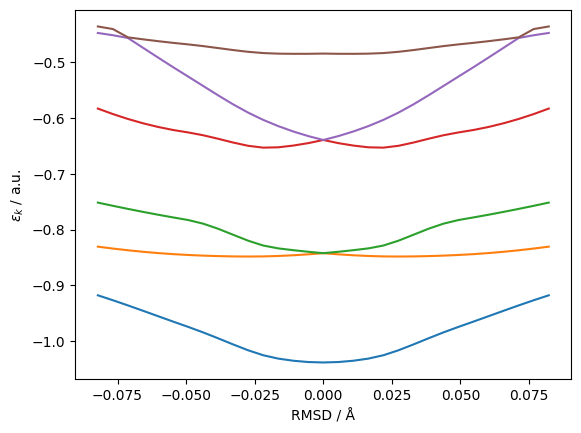

In [ ]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")
# plt.savefig("../figures/benzene-deformations.svg")

## Invariant H

In [123]:
dataset_inv = QMDataset(frames = [frame], 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=[fock],
                   device = device, 
                   orbs = orbitals['benzene_inv'], 
                   orbs_name = None
                   )

In [124]:
dataset_displaced_inv = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=False,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = orbitals['benzene_inv'], 
                              orbs_name = None
                              )

In [125]:
target_coupled_blocks_inv = get_targets(dataset_inv, cutoff = cutoff, device = device)

In [20]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks_inv,
                                  frames = dataset.structures, 
                                  orbitals = dataset_inv.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_inv,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                        )
print(loss_ridge_bias)

tensor(82.1192)


In [21]:
fock_pred  = next(iter(blocks_to_matrix(pred_ridge_bias, dataset_inv)[0].values()))

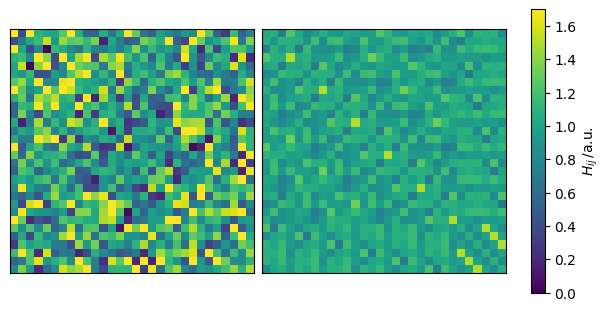

In [22]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(fock_pred, vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

1.477862714373585
0.016273980152756308
0.11758709927229476


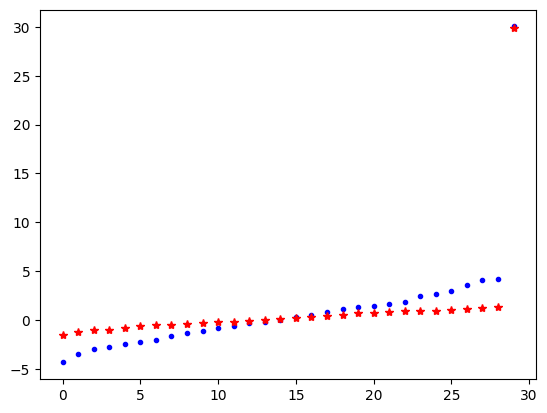

In [23]:
eva_ref = np.linalg.eigvalsh(fock)
eva_pred = np.linalg.eigvalsh(fock_pred)
plt.plot(eva_ref, 'b.')
plt.plot(eva_pred, 'r*') 
print(np.sqrt(np.mean((np.linalg.eigvalsh(fock)-np.linalg.eigvalsh(fock_pred))**2)))
print(np.linalg.eigvalsh(fock)[14])
print(np.linalg.eigvalsh(fock_pred)[14])

In [27]:
pred_disp = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_d)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:866: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [28]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced_inv)
fock_disp = [f[0,0,0].numpy() for f in fockd]

In [29]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

Text(0.5, 1.0, 'invariant')

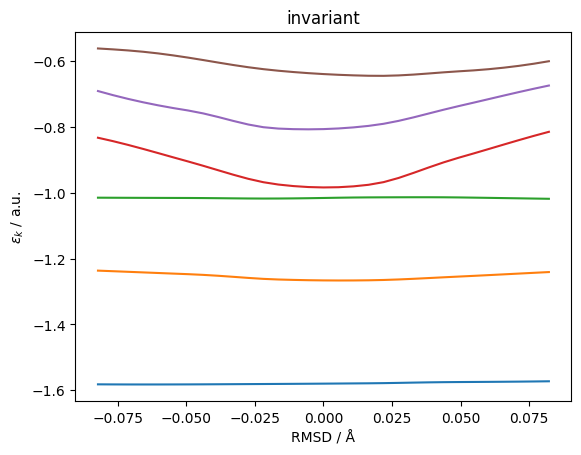

In [30]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")
plt.title('invariant')
# plt.savefig("../figures/benzene-deformations.svg")

# TORCH

In [25]:
# from mlelec.models.linear_integrated import LinearModelPeriodic


In [16]:
target_keynames = target_coupled_blocks.keys.names
keys = []
blocks= []
for k,b in target_coupled_blocks.items(): 
    li, lj, L = k['l_i'], k['l_j'], k['L']
    inversion_sigma = (-1) ** (li + lj + L)
    keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
    blocks.append(b.copy())
target_coupled_blocks = TensorMap( Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
                 
target_coupled_blocks_copy = target_coupled_blocks.copy()
target_coupled_blocks = target_coupled_blocks.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

In [19]:
target_coupled_blocks .keys.names

['block_type', 'species_i', 'species_j', 'L', 'inversion_sigma']

In [18]:
target_coupled_blocks.property_names

['n_i', 'l_i', 'n_j', 'l_j', 'dummy']

### Train matrix

In [27]:
model =  LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [28]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [29]:
losses = []
test_losses = []
BEST = 1e13
for epoch in range(1001):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    
    loss = L2_loss(target_coupled_blocks, pred)
    # loss = L2_loss(target_k, predk)
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        # model.train= False
        # test_pred = model.predict(hfeat_test, test_coupled_blocks)
        # test_loss = L2_loss(test_pred, test_coupled_blocks)
        # test_losses.append(test_loss.item())
        # # print(epoch, test_loss.item())
        
        # if test_loss<BEST:
        #     # print('new_best')
        #     BEST = test_loss
        #     checkpoint = {'model_statedict':model.state_dict, 
        #                   'optimizer_statedict':optim.state_dict,
        #                   'train loss':loss,
        #                   'test_loss': test_loss,
        #                   'pred': model()
        #                  }
        #     # torch.save(checkpoint, 'checkpoint_2.pt')
        # model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item())#, test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 761.1750823051082
100 536.952637808095
200 534.006510561811
300 534.0064993211787
400 534.0064598065721
500 534.0064598045009
600 534.0064694744127
700 534.0064598123606
800 534.006459804501
900 534.0064598045009
1000 534.0064598045009


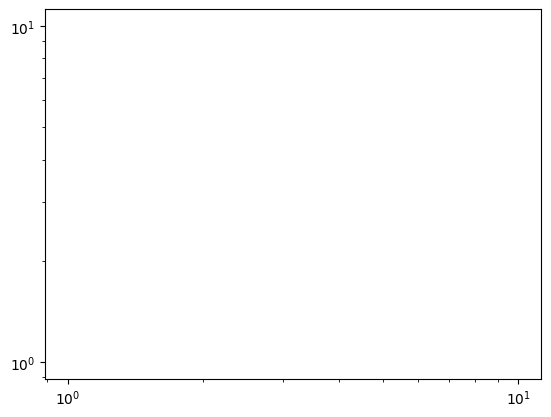

In [30]:
plt.loglog(test_losses)

### Train eigvals

This training should not make a zero error, as the prediction will always have the degeneracy compatible with the characters of the eigstates whereas the randomly generated reference will not, so the model will approximate the two and not be able to learn the spectrum perfectly even for one structure 

In [11]:
def eigval_loss(pred, target):
    eva_pred = torch.linalg.eigvalsh(pred)
    eva_target = torch.linalg.eigvalsh(target)
    assert eva_pred.shape == eva_target.shape
    return torch.sum(eva_pred-eva_target)**2

In [12]:
model =  LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [13]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [14]:
target_eigvals = torch.linalg.eigvalsh(torch.from_numpy(dataset.fock_realspace[0]))

In [139]:
losses = []
test_losses = []
BEST = 1e13
for epoch in range(501):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    reconmat = next(iter(blocks_to_matrix(pred, dataset)[0].values()))
    pred_eigvals = torch.linalg.eigvalsh(reconmat)
    # loss = eigval_loss(fock , reconmat)
    loss = L2_loss(target_eigvals, pred_eigvals)
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        # model.train= False
        # test_pred = model.predict(hfeat_test, test_coupled_blocks)
        # test_loss = L2_loss(test_pred, test_coupled_blocks)
        # test_losses.append(test_loss.item())
        # # print(epoch, test_loss.item())
        
        # if test_loss<BEST:
        #     # print('new_best')
        #     BEST = test_loss
        #     checkpoint = {'model_statedict':model.state_dict, 
        #                   'optimizer_statedict':optim.state_dict,
        #                   'train loss':loss,
        #                   'test_loss': test_loss,
        #                   'pred': model()
        #                  }
        #     # torch.save(checkpoint, 'checkpoint_2.pt')
        # model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item())#, test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 9311.600164594387
100 1124.1454440874516
200 5.072737479431873
300 5.0000021520887685
400 5.000000000015382
500 4.999999999999937


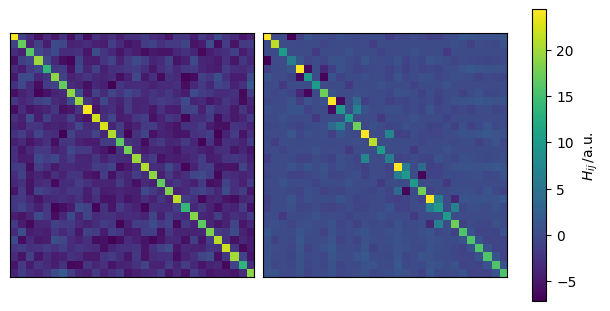

In [141]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock.real)#, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(reconmat.detach().numpy())#, vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

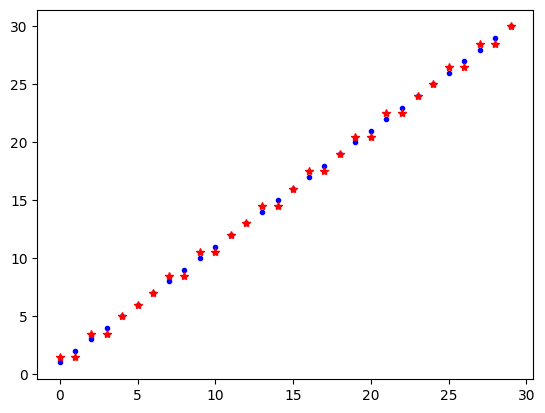

In [142]:
plt.plot(target_eigvals, 'b.')
pred = model()
    # predk = TMap_bloch_sums(pred, phase)
reconmat = next(iter(blocks_to_matrix(pred, dataset)[0].values()))
pred_eigvals = torch.linalg.eigvalsh(reconmat.detach())

plt.plot(pred_eigvals, 'r*')

In [38]:
pred_disp = model.predict(features=hfeat_d)
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
fock_disp = [f[0,0,0].detach().numpy() for f in fockd]

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:615: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [39]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

The prediction still maintains the compatibility with the Jahn-Teller effect as we still model an intermediate H

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

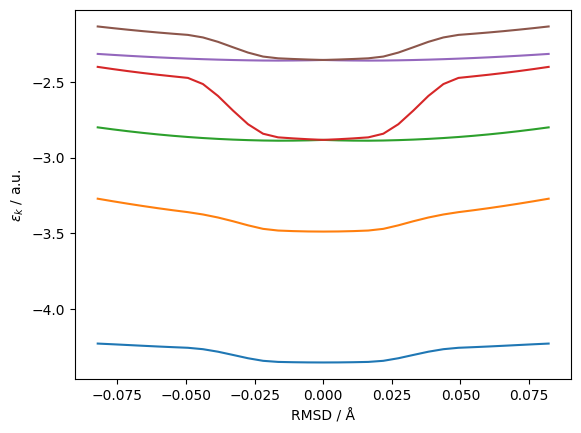

In [40]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")

## Invariant intermediate H

we are able to make a much smaller error here than in the previous case 

In [126]:
model =  LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks_inv,
                            frames = dataset_inv.structures, orbitals = dataset_inv.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [127]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [128]:
target_eigvals = torch.linalg.eigvalsh(torch.from_numpy(dataset_inv.fock_realspace[0]))

In [129]:
# losses = []
# test_losses = []
# BEST = 1e13
for epoch in range(5001):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    reconmat = next(iter(blocks_to_matrix(pred, dataset_inv)[0].values()))
    pred_eigvals = torch.linalg.eigvalsh(reconmat)
    # loss = eigval_loss(fock , reconmat)
    loss = L2_loss(target_eigvals, pred_eigvals)
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        # model.train= False
        # test_pred = model.predict(hfeat_test, test_coupled_blocks)
        # test_loss = L2_loss(test_pred, test_coupled_blocks)
        # test_losses.append(test_loss.item())
        # # print(epoch, test_loss.item())
        
        # if test_loss<BEST:
        #     # print('new_best')
        #     BEST = test_loss
        #     checkpoint = {'model_statedict':model.state_dict, 
        #                   'optimizer_statedict':optim.state_dict,
        #                   'train loss':loss,
        #                   'test_loss': test_loss,
        #                   'pred': model()
        #                  }
        #     # torch.save(checkpoint, 'checkpoint_2.pt')
        # model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item())#, test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 9131.682995057123
100 314.22732322683976
200 0.9311037376239999
300 0.6476017590709002
400 0.3702003997601596
500 0.11370454276007406
600 0.03773833505263986
700 0.021380118775705663
800 0.013209380637019234
900 0.007779770775580188
1000 0.004430824751013412
1100 0.005464547779136495
1200 0.001615761028521637
1300 0.0008720788482455544
1400 0.00045729067007422067
1500 0.00020342956399729982


KeyboardInterrupt: 

In [130]:
pred

TensorMap with 32 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
          -1          6       2    0       6       3    0   0
          -1          6       2    0       6       4    0   0
          -1          6       2    0       6       5    0   0
          -1          6       3    0       6       4    0   0
          -1          6       3    0       6       5    0   0
          -1          6       4    0       6       5    0   0
          0           1       1    0       1       1    0   0
          0           6       2    0       6       2    0   0
          0           6       2    0       6       3    0   0
          0           6       2    0       6       4    0   0
          0           6       2    0       6       5    0   0
          0           6       3    0       6       3    0   0
          0           6       3    0       6       4    0   0
          0           6       3    0       6       5    0   0
          0           6       4    0       6 

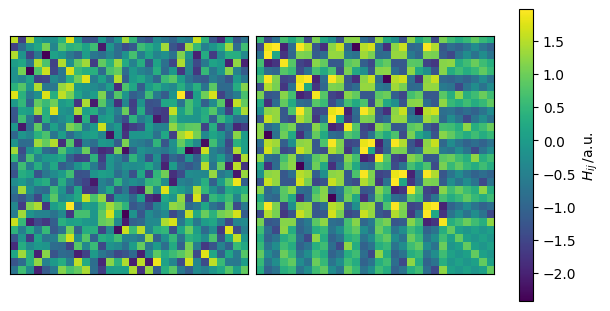

In [86]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock)#, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(reconmat.detach().numpy())#, vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

In [131]:
pred = model()
reconmat = next(iter(blocks_to_matrix(pred, dataset_inv)[0].values()))
print("Error in H, " , L2_loss(reconmat, torch.from_numpy(fock)))
print(r"Error in $\epsilon$, ", L2_loss(target_eigvals, torch.linalg.eigvalsh(reconmat)))

Error in H,  tensor(4313.8213, grad_fn=<PowBackward0>)
Error in $\epsilon$,  tensor(9.8373e-05, grad_fn=<PowBackward0>)


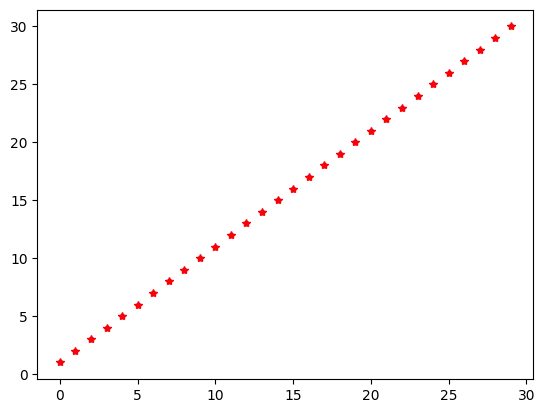

In [132]:
plt.plot(target_eigvals, 'b.')
pred = model()
    # predk = TMap_bloch_sums(pred, phase)
reconmat = next(iter(blocks_to_matrix(pred, dataset_inv)[0].values()))
pred_eigvals = torch.linalg.eigvalsh(reconmat.detach())

plt.plot(pred_eigvals, 'r*')

In [80]:
[p.item() for p in pred_eigvals]

[-2.214680952016691,
 -1.5593986732893084,
 -1.5430256062376337,
 -1.5401867460384597,
 -1.532082136681476,
 -1.522522959051789,
 -1.2138790314768115,
 -0.6368548852311653,
 -0.6081840514602689,
 -0.6078845201751629,
 -0.6041620989009012,
 -0.5867484630412937,
 -0.12197263085197722,
 0.5079125123526818,
 0.5102739645792476,
 0.510377937352423,
 0.5126785586307842,
 0.5130458791136531,
 0.9392560206454674,
 1.2645647670160876,
 1.3310272482155294,
 1.3391228471220535,
 1.3529464395718478,
 1.9654527490862126,
 2.1293654793377903,
 2.1341687741439515,
 2.1774942795141325,
 2.2647989013714804,
 2.6270596648832205,
 4.399273927775159]

In [89]:
pred_disp_inv = model.predict(features=hfeat_d)
fockd_inv = blocks_to_matrix(pred_disp_inv, dataset_displaced_inv)
fock_disp_inv = [f[0,0,0].detach().numpy() for f in fockd_inv]

In [90]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp_inv]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

The prediction, as expected, cannot maintain the compatibility with the Jahn-Teller effect as the intermediate invairant H loses all symmetries

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

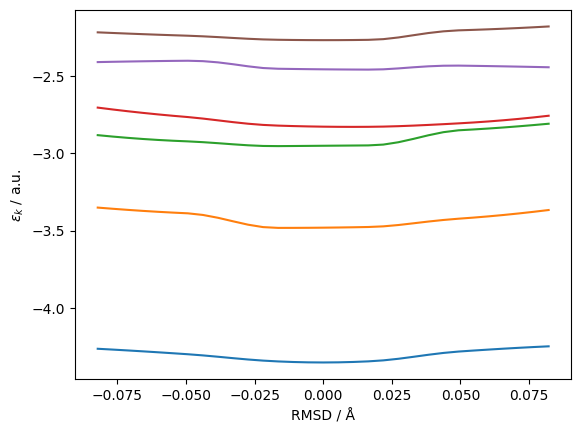

In [91]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")

## Learn a smaller invariant basis

### Model first 12 states 

In [41]:
fockdummy = []
for i,d in enumerate(ld):
    # fockdummy.append(torch.zeros(12,12))
    # fockdummy.append(torch.zeros(18,18))
    fockdummy.append(torch.zeros(24,24))

In [42]:
dataset_smallbasis = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=True,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = {6: [[2,1,0],[2,1,1],[2,1,-1]],#,[3,0,0]],
                                           1:[[1,0,0]]}, 
                              orbs_name = None
                              )
target_coupled_blocks = get_targets(dataset_smallbasis, cutoff = cutoff, device = device)

In [43]:
target_coupled_blocks

TensorMap with 8 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j  L
          -1          6       2    1       6       2    1   1
          0           1       1    0       1       1    0   0
          0           6       2    1       6       2    1   0
          0           6       2    1       6       2    1   2
          1           1       1    0       1       1    0   0
          1           6       2    1       6       2    1   0
          1           6       2    1       6       2    1   2
          2           1       1    0       6       2    1   1

In [26]:
dataset_displaced_smallbasis = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=True,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = dataset_smallbasis.basis, 
                              orbs_name = None
                              )


In [48]:
model =  LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset_smallbasis.structures, orbitals = dataset_smallbasis.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [49]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [45]:
# target_eigvals = torch.linalg.eigvalsh(torch.from_numpy(fock))[:12] 
target_eigvals = torch.linalg.eigvalsh(torch.from_numpy(dataset.fock_realspace[0]))[:len(fockdummy[0])]#[1:12]

In [52]:
target_eigvals

tensor([ 1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,  8.0000,
         9.0000, 10.0000, 11.0000, 12.0000, 13.0000, 14.0000, 15.0000, 16.0000,
        17.0000, 18.0000, 19.0000, 20.0000, 21.0000, 22.0000, 23.0000, 24.0000])

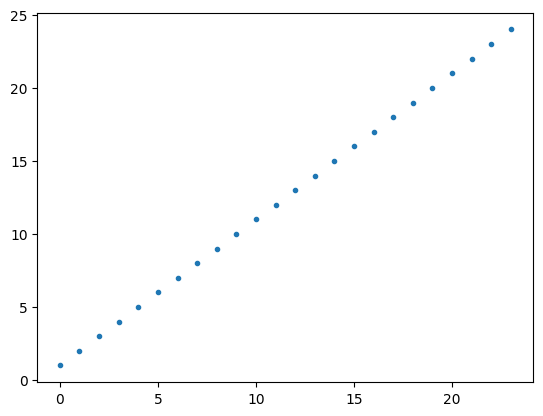

In [46]:
plt.plot(target_eigvals,'.')
# plt.plot(pred_eigvals.detach(),'r.')

In [31]:
pred = model()
    # predk = TMap_bloch_sums(pred, phase)
reconmat = next(iter(blocks_to_matrix(pred, dataset_smallbasis)[0].values()))
pred_eigvals = torch.linalg.eigvalsh(reconmat)


In [50]:
losses = []
test_losses = []
BEST = 1e13
for epoch in range(5001):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    reconmat = next(iter(blocks_to_matrix(pred, dataset_smallbasis)[0].values()))
    pred_eigvals = torch.linalg.eigvalsh(reconmat)
    # loss = eigval_loss(fock , reconmat)
    loss = L2_loss(target_eigvals, pred_eigvals[:])#[1:12]
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        # model.train= False
        # test_pred = model.predict(hfeat_test, test_coupled_blocks)
        # test_loss = L2_loss(test_pred, test_coupled_blocks)
        # test_losses.append(test_loss.item())
        # # print(epoch, test_loss.item())
        
        # if test_loss<BEST:
        #     # print('new_best')
        #     BEST = test_loss
        #     checkpoint = {'model_statedict':model.state_dict, 
        #                   'optimizer_statedict':optim.state_dict,
        #                   'train loss':loss,
        #                   'test_loss': test_loss,
        #                   'pred': model()
        #                  }
        #     # torch.save(checkpoint, 'checkpoint_2.pt')
        # model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item())#, test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 4793.168359200714
100 310.57534918325877
200 4.003932089850558
300 4.000000037428121
400 4.000000000002553


KeyboardInterrupt: 

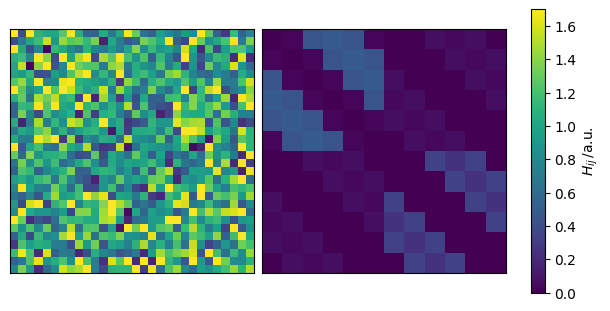

In [127]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(reconmat.detach().numpy(), vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

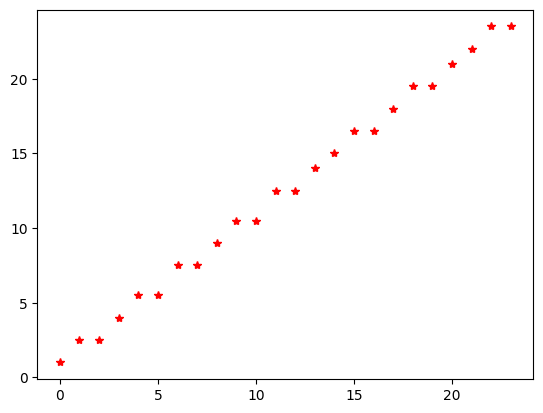

In [51]:
# plt.plot(target_eigvals, 'b.')
pred = model()
    # predk = TMap_bloch_sums(pred, phase)
reconmat = next(iter(blocks_to_matrix(pred, dataset_smallbasis)[0].values()))
pred_eigvals = torch.linalg.eigvalsh(reconmat.detach())

# plt.plot(pred_eigvals[1:12], 'r*')
plt.plot(pred_eigvals, 'r*')

In [187]:
[p.item() for p in pred_eigvals]

[-1.5992862061227247,
 -0.8299283666712473,
 -0.10226233751867762,
 -0.10226233030937645,
 -0.10214876375734278,
 -0.10214876293373386,
 -0.10209804899538513,
 0.00442204408814862,
 0.006269688862407432,
 0.007926202011994711,
 0.008325179118876811,
 0.01143023027992779,
 0.30273558716994897,
 0.30284565924457296,
 0.3028747458160815,
 0.30626219009318695,
 0.3065119203661214,
 1.7057363493273794]

In [129]:
pred_disp_inv = model.predict(features=hfeat_d)
fockd_inv = blocks_to_matrix(pred_disp_inv, dataset_displaced_smallbasis)
fock_disp_inv = [f[0,0,0].detach().numpy() for f in fockd_inv]

In [130]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp_inv]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

The prediction, as expected, cannot maintain the compatibility with the Jahn-Teller effect as the intermediate invairant H loses all symmetries

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

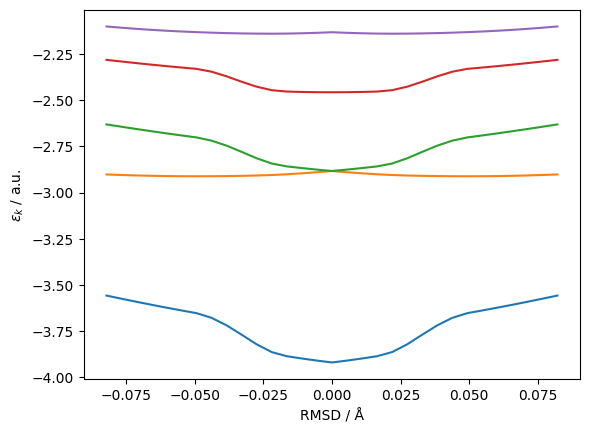

In [131]:
for k in range(1,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")

### Model any 4 random states